<hr style="border:30px solid Firebrick "> </hr>
<hr style="border:2px solid Firebrick "> </hr>

# Agentic Workflow Automation for Northwestern Memorial Hospital
**Author:** Atef Bader, PhD

**Last Edit:** 12/17/2024



## Goals

- Automate Call/Inquiry processing using Langgraph/Langchain with OpenAI
- Use OpenAI to route and answer user's questions directed to different departments represented by different agents for Northwestern Memorial Hospital

<hr style="border:2px solid Firebrick "> </hr>


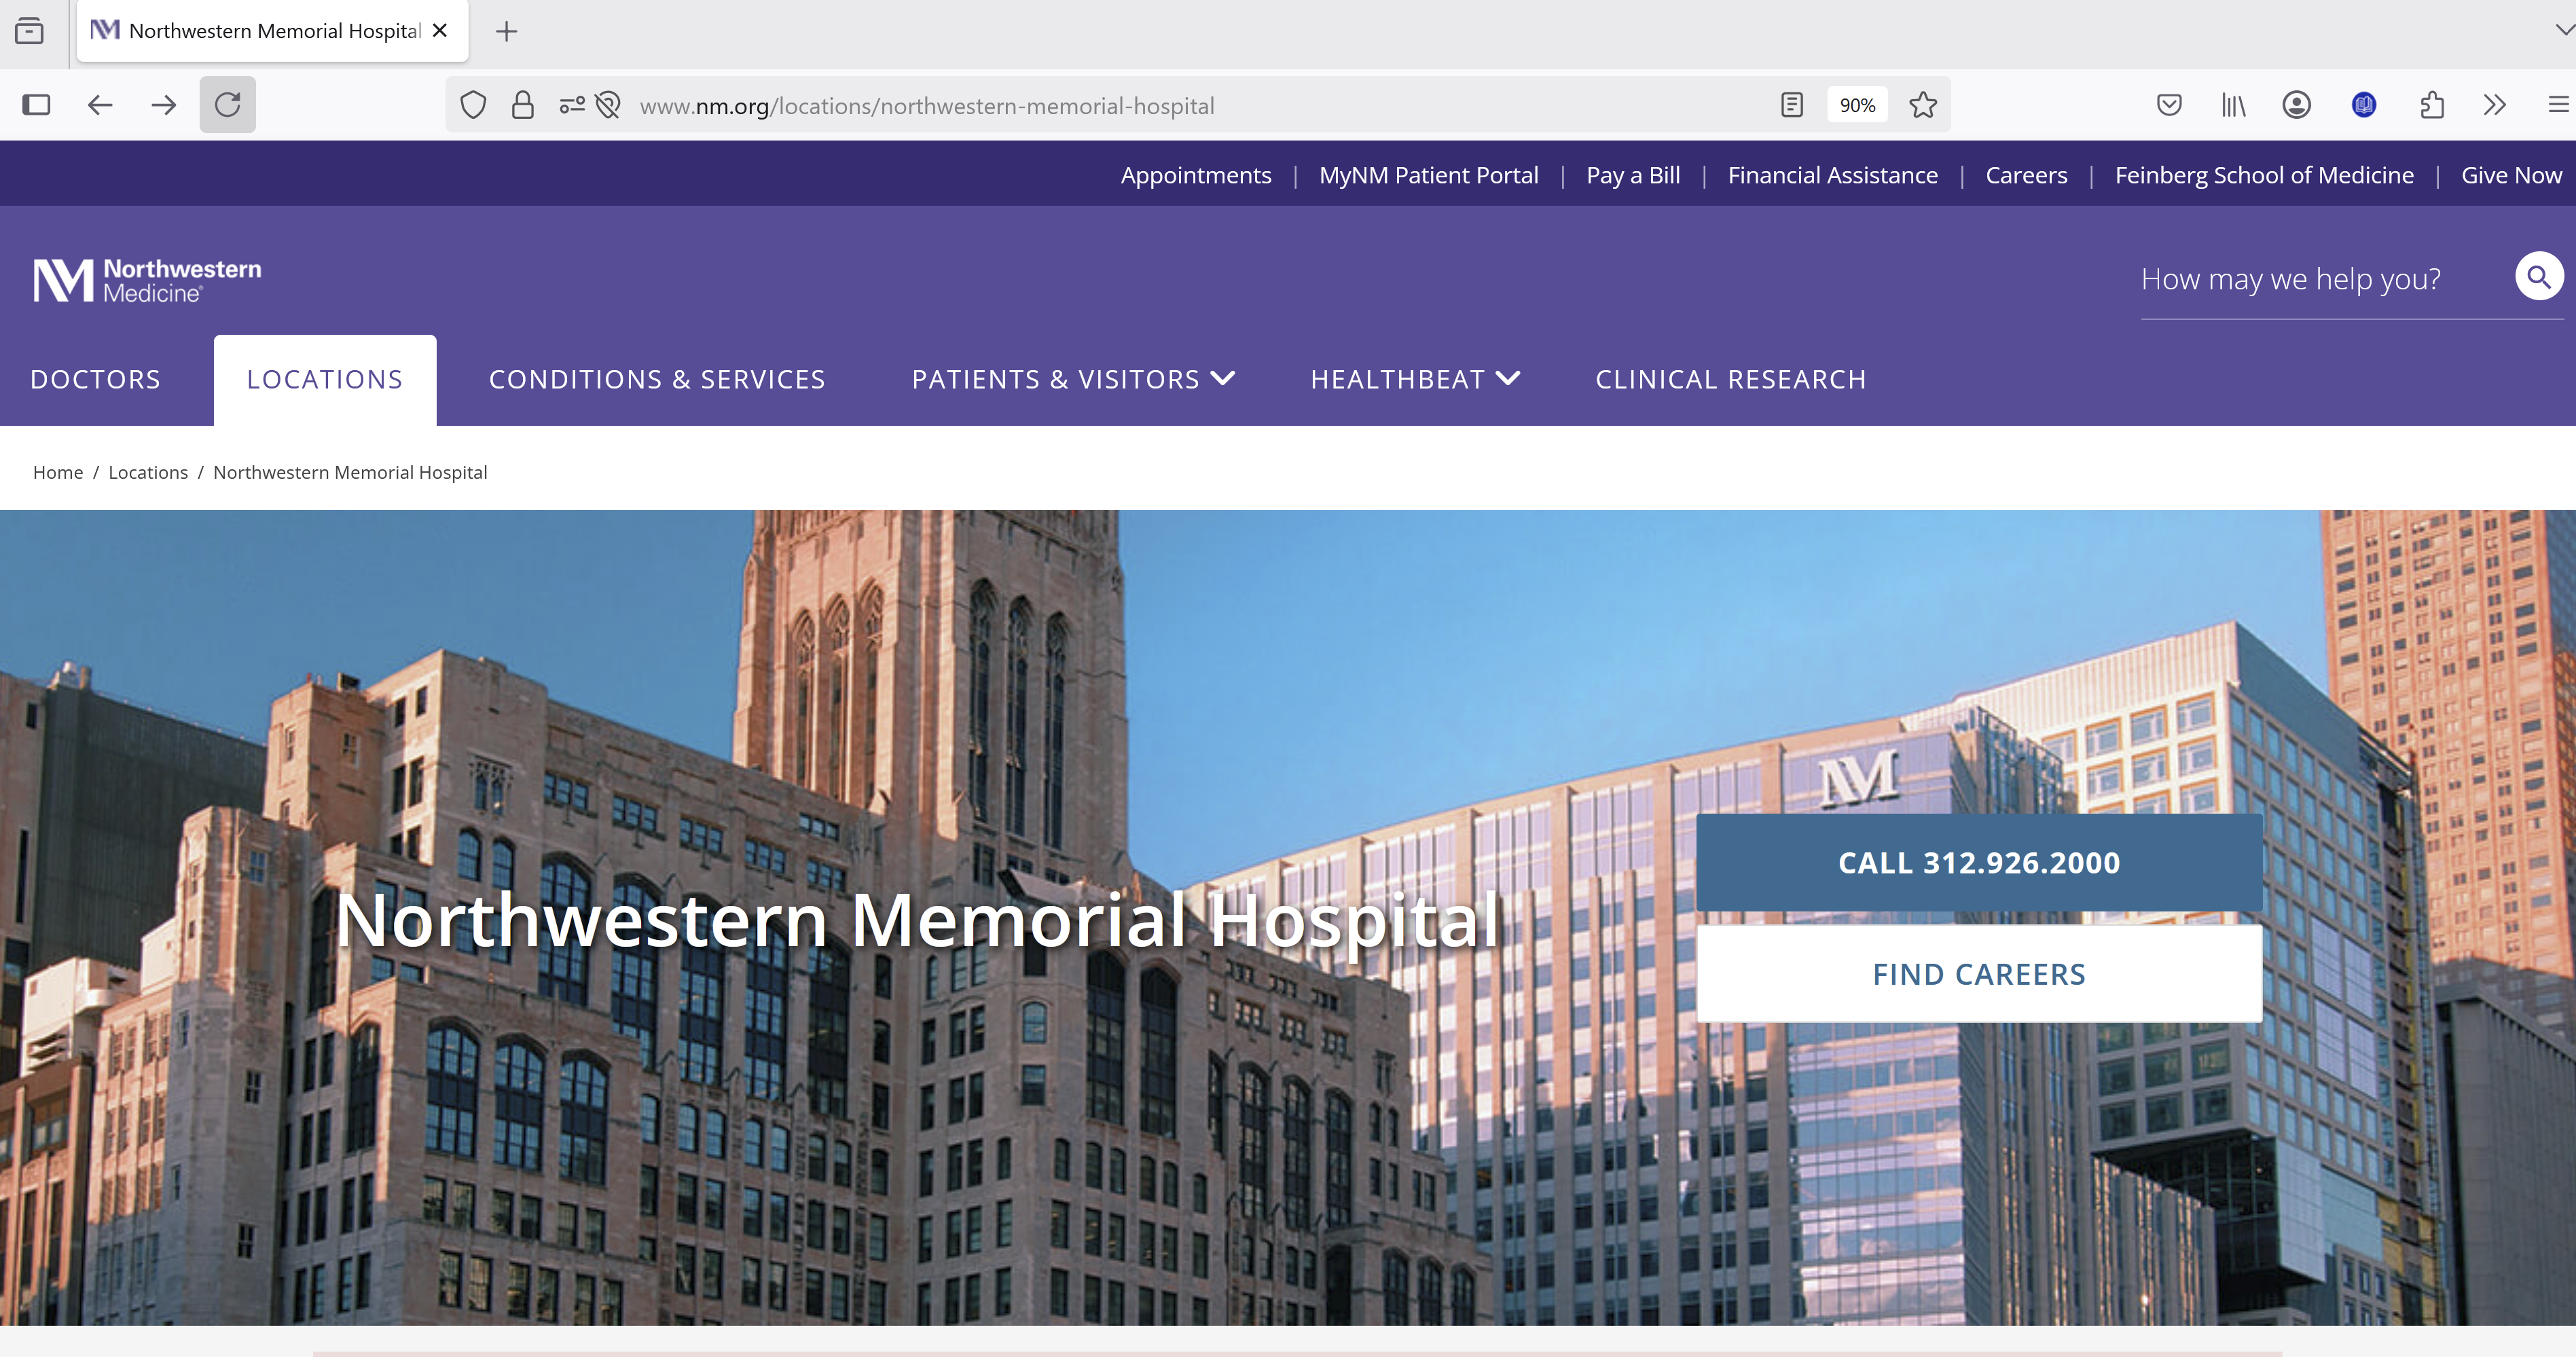


<hr style="border:5px solid orange "> </hr>


In [ ]:
%%capture --no-stderr
%pip install uv
%uv pip install chromadb==0.4.22
%uv pip install tiktoken==0.9.0
%uv pip install langchain==0.3.20
%uv pip install langchain-community==0.3.10
%uv pip install langchain-openai==0.3.1
%uv pip install langchainhub
%uv pip install langchain-text-splitters==0.3.6
%uv pip install langgraph==0.3.1
%uv pip install openai==1.65.3
%uv pip install PyMuPDF==1.25.3
%uv pip install pypdf==5.3.1
%uv pip install pillow==11.1.0
%uv pip install beautifulsoup4==4.13.3
%uv pip install  mermaid_cli
%uv pip install grandalf
    
  

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import Image, display


from typing import Any
from typing_extensions import TypedDict
import operator
from typing import Annotated


from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from langgraph.graph.message import add_messages


In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


In [ ]:
# Requirement 1: Define the structure of agent state for the LangGraph
class InquiryState(TypedDict):
    inquiry: str
    next_node: str
    response: str  


In [ ]:
def operator_router(state):

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    query = f"""Classify the user's intents based on the following input: '{state['inquiry']}'. 
            List of possible intent values: Greeting, GeneralInquiry, ER, Radiology, PrimaryCare, Cardiology, Pediatrics, BillingInsurance
            Return only the intent value of the inquiry identified with no extra text or characters"""
    
    human_message = HumanMessage(
        content=[
            {"type": "text", "text": query},
        ],
    )

    system_message = SystemMessage(content="You are a helpful assistant tasked with classifying the intent of user's inquiry")
    
    response = llm.invoke([system_message]+[human_message])
    intent = response.content.strip()
            
    response_lower = intent.lower()
    
    if "greeting" in response_lower:
        response = "Hello there, This is Northwestern Memorial Hospital, How can I assisst you today?"
        next_node = END
    elif "generalinquiry" in response_lower:
        response = "For general informtion about nearby parking, hotels and restaurants, please visit https://www.nm.org/ and navigate to Patients & Visitors link "
        next_node = END
    else:
        response = None
        next_node = intent

        
    
    return {
        "inquiry": state["inquiry"],
        "next_node": next_node,
        "response": response
    }


In [ ]:
def er_agent(state):
    print("\n\n ER KNOWLEDGE-BASE IS EMPTY \n\n ")
    return {"inquiry": state["inquiry"], "next_node": END, "response": "ER: YOU NEED TO ADD-YOUR-KNOWLEDGE-BASE"}


In [ ]:
def radiology_agent(state):
    print("\n\n Radiology KNOWLEDGE-BASE IS EMPTY \n\n ")
    return {"inquiry": state["inquiry"], "next_node": END, "response": "Radiology: YOU NEED TO ADD-YOUR-KNOWLEDGE-BASE"}
    

In [ ]:
def primary_care_agent(state):
    print("\n\n Primary Care KNOWLEDGE-BASE IS EMPTY \n\n ")
    return {"inquiry": state["inquiry"], "next_node": END, "response": "Primary Care: YOU NEED TO ADD-YOUR-KNOWLEDGE-BASE"}
    

In [ ]:
def cardiology_agent(state):

    knowledge_base = """
        "inquiry": "Do you have any available appointments with a cardiologist next week?",
         "response": "Appointment availability varies. New patients typically need a referral. Provide the exact date you are looking for so we can check for availability",
         
        "inquiry": "What tests are done during a heart check-up?",
         "response": "Standard tests include EKG, blood pressure, cholesterol screening, and physical exam. Additional tests ordered as needed.",
         
        "inquiry": "How should I prepare for a stress test?",
         "response": "Wear comfortable clothes and walking shoes. Avoid caffeine and heavy meals before the test. Bring a list of medications.",
         
        "inquiry": "What do you recommend to watch for to see if I have signs of heart problems?",
         "response": "Watch for chest pain, shortness of breath, irregular heartbeat, fatigue, and swelling in legs. Go to ER for severe symptoms."},

        "inquiry": "Do you offer heart screenings?",
         "response": "Yes, we provide preventive screenings including calcium scoring, cholesterol tests, and blood pressure monitoring.",
 
        """
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    
    query = f"""Provide an answer for following user's inquiry: '{state['inquiry']}' using the knowledge_base"""
    
    human_message = HumanMessage(
        content=[
            {"type": "text", "text": query},
        ],
    )

    system_message = SystemMessage(content=f"You are a helpful assistant tasked with answering user's inquiry based on the answers you have in this knowledge_base only: {knowledge_base}")
    
    response = llm.invoke([system_message]+[human_message])
    formatted_response = "Cardiology:: " + response.content.strip()
    
    
    return {"input": state["inquiry"], "next_node": END, "response": formatted_response}



In [ ]:
def pediatrics_agent(state):
    print("\n\n Pediatrics KNOWLEDGE-BASE IS EMPTY \n\n ")
    return {"input": state["inquiry"], "next_node": END, "response": "Pediatrics: YOU NEED TO ADD-YOUR-KNOWLEDGE-BASE."}


In [ ]:
def billing_agent(state):
    print("\n\n BillingInsurance KNOWLEDGE-BASE IS EMPTY \n\n ")
    return {"input": state["inquiry"], "next_node": END, "response": "BillingInsurance: YOU NEED TO ADD-YOUR-KNOWLEDGE-BASE"}
    

In [ ]:

builder = StateGraph(InquiryState)

builder.add_node("Operator", operator_router)
builder.add_node("ER", er_agent)
builder.add_node("Radiology", radiology_agent)
builder.add_node("PrimaryCare", primary_care_agent)
builder.add_node("Cardiology", cardiology_agent)
builder.add_node("Pediatrics", pediatrics_agent)
builder.add_node("BillingInsurance", billing_agent)

builder.set_entry_point("Operator")

builder.add_conditional_edges(
    "Operator",
    lambda x: x["next_node"],
    {
        "ER": "ER",
        "PrimaryCare": "PrimaryCare",
        "Pediatrics": "Pediatrics",
        "Radiology": "Radiology",
        "Cardiology": "Cardiology",
        "BillingInsurance": "BillingInsurance",
        END: END
    }
)

for node in ["ER", "Radiology", "PrimaryCare", "Cardiology", "Pediatrics", "BillingInsurance"]:
    builder.add_edge(node, END)


graph = builder.compile()


In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
# Sample inquiries
# My child has a fever
# I need help with my medical bill
# Can I visit my friend in the ER?
# Do I need to fast for my scan?
# I want to schedule my cardiology appointment
# I want to see my doctor for my annual exam

while True:
    user_input = input("User: ")
    if user_input.lower() in {"q", "quit"}:
        print("Goodbye!")
        break
    result = graph.invoke({"inquiry": user_input})
    
    response = result.get("response", "No Response Returned")
    print(f"\n\nResponse:\n\n {response} \n\n")
    


<br><br><br>

<hr style="border:30px solid coral "> </hr>
<hr style="border:2px solid coral "> </hr>


# Requirements Specification:

<hr style="border:2px solid coral "> </hr>


### Implementation Requirements:

Provide runs that will demonstrate a fully functional application for every case listed below:
1. The knowledge base for every agent
    - Knowledge Base can be generated by any GenAI model (ChatGPT, Gemini, Claude, etc.)
    - Knowledge Base can be stored in any data structure, file, or vector database
2. Multiturn conversation with every agent (For example, A person called Cardialogy Department asking for cause of their pain then decided to schedule an appointment to see cardialogist)
3. Transactions like booking an appointment or making a payment can be stored in any data structure (DataFrame, Array, List, Dictionary, ...), or file (CSV, JSON, Plaintext)
4. Your Agents must be able to answer EVERY question/inquiry listed below:
    - **ER (Emergency Room)**
        - When should I visit the ER instead of urgent care?
        - How long will I wait to be seen in the ER?
    - **Radiology**
        - How should I prepare for my MRI or CT scan?
        - When and how will I receive my imaging results?
    - **Primary Care**
        - How do I schedule or cancel an appointment?
        - Can I get a same-day visit for urgent issues?
    - **Cardiology**
        - What are common signs that I need to see a cardiologist?
        - What should I expect during a heart stress test?
    - **Pediatrics**
        - What vaccines does my child need at each age?
        - What should I do if my child develops a high fever?
    - **Billing & Insurance**
        - What insurance plans do you accept?
        - How can I view, understand, or pay my bill?
5. My name is Ashley Smith and I want to know the amount I owe you so I can pay it now using my CC.
6. My name is Johnatan Walter , I have an appointment with my doctor scheduled for Tuesday next week at 1:00pm and I want to change it to Thursday morning next week, whaat time slots are available on Thursday?
